In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob 
from scipy.io.wavfile import read
import IPython.display as ipd
import librosa
import librosa.display
import librosa.feature
import pickle
import sklearn

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Lambda,Input, concatenate, Conv2DTranspose, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.utils import np_utils
from keras.utils import to_categorical
from keras import optimizers 
from keras.models import load_model
from keras.models import model_from_json

import keras.backend as K 
# K.set_image_dim_ordering('tf')
print('Image ordering is tf check: ',K.image_dim_ordering())

In [4]:
X = np.load('X_FINAL.npy')
Y = np.load('Y_FINAL.npy')
    
print('Shape of X: ',X.shape)
print('Shape of Y: ',Y.shape)

for lab in range(0,12):
    print('Number of samples in class: '+str(lab) +' = ',len(np.where(Y==lab)[0]))

Shape of X:  (140767, 128, 51, 1)
Shape of Y:  (140767, 1)
Number of samples in class: 0 =  9436
Number of samples in class: 1 =  9488
Number of samples in class: 2 =  9412
Number of samples in class: 3 =  9500
Number of samples in class: 4 =  9428
Number of samples in class: 5 =  9468
Number of samples in class: 6 =  9468
Number of samples in class: 7 =  9520
Number of samples in class: 8 =  9500
Number of samples in class: 9 =  9508
Number of samples in class: 10 =  41039
Number of samples in class: 11 =  5000


In [5]:
rand = np.random.permutation(X.shape[0])
n = 130000
tr = rand[0:n]
te = rand[n:]
X_tr = X[tr]
Y_tr = Y[tr]

X_te = X[te]
Y_te = Y[te]

print('Shape of training: ',X_tr.shape)
print('Shape of testing: ',X_te.shape)

Shape of training:  (130000, 128, 51, 1)
Shape of testing:  (10767, 128, 51, 1)


In [6]:
#In training set 
print('\n In training set')
for lab in range(0,12):
    print('Number of samples in class: '+str(lab) +' = ',len(np.where(Y_tr==lab)[0]))

#In testing set 
print('\n In testing set')
for lab in range(0,12):
    print('Number of samples in class: '+str(lab) +' = ',len(np.where(Y_te==lab)[0]))


 In training set
Number of samples in class: 0 =  8717
Number of samples in class: 1 =  8768
Number of samples in class: 2 =  8695
Number of samples in class: 3 =  8765
Number of samples in class: 4 =  8703
Number of samples in class: 5 =  8753
Number of samples in class: 6 =  8747
Number of samples in class: 7 =  8776
Number of samples in class: 8 =  8750
Number of samples in class: 9 =  8832
Number of samples in class: 10 =  37906
Number of samples in class: 11 =  4588

 In testing set
Number of samples in class: 0 =  719
Number of samples in class: 1 =  720
Number of samples in class: 2 =  717
Number of samples in class: 3 =  735
Number of samples in class: 4 =  725
Number of samples in class: 5 =  715
Number of samples in class: 6 =  721
Number of samples in class: 7 =  744
Number of samples in class: 8 =  750
Number of samples in class: 9 =  676
Number of samples in class: 10 =  3133
Number of samples in class: 11 =  412


### One hot encoding output labels Y 

In [7]:
Y_tr = to_categorical(Y_tr)
Y_te = to_categorical(Y_te)
print(Y_tr.shape)
print(Y_te.shape)

(130000, 12)
(10767, 12)


In [13]:
input_shape = (128,51,1)

model = Sequential([
    BatchNormalization(axis = -1,input_shape = input_shape),

    Conv2D(32, (2, 2),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,   
    
   
    Conv2D(64, (2, 2),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)  ,
    
    
    Conv2D(128, (2, 2),strides = (1,1), padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,

    
    Conv2D(256, (2, 2),strides = (1,1),padding='same',activation='relu'),
    BatchNormalization(axis = -1),
    MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) ,
    
    
    Flatten(),
    Dropout(0.2),

    
    Dense(512,activation = 'relu'),    
    Dense(12,activation='softmax')
    
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 51, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 6, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 6, 256)        295168    
__________

In [9]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc =[]
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()

In [16]:
opt = optimizers.Adam(lr=0.001) 
model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
batch_size = 100
model.fit(np.array(X_tr), np.array(Y_tr), batch_size=batch_size, epochs=1, verbose=1, validation_data=(np.array(X_te), np.array(Y_te)), callbacks = [history_cb])

Train on 130000 samples, validate on 10767 samples
Epoch 1/1
130000/130000 [==============================] - 2797s 22ms/step - loss: 0.7620 - acc: 0.7414 - val_loss: 0.5061 - val_acc: 0.8247


In [73]:
json_string = model.to_json()
with open('models/model2_json.pkl', 'wb') as m:
    pickle.dump(json_string, m)
model.save_weights('models/model2_weights.h5')

In [ ]:
# model reconstruction from JSON:
json_string = pickle.load( open( "models/model2_json.pkl", "rb" ) )
model = model_from_json(json_string)
model.load_weights('models/model2_weights.h5')

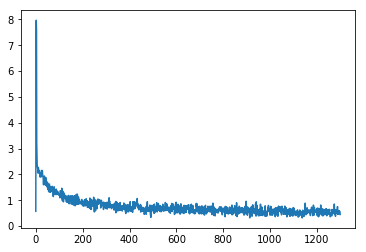

In [84]:
#Plotting loss
plt.plot(history_cb.loss)
plt.show()

In [86]:
p = model.predict(X_te)
#Converting from one hot back to integers
y_pred = [np.where(r==np.max(r))[0][0] for r in p]


a = Y_te
#Converting from one hot back to integers
y_true = [np.where(r==1)[0][0] for r in a ]

C = sklearn.metrics.confusion_matrix(y_true,y_pred, labels=None, sample_weight=None)
S = np.sum(np.array(C),axis=1)
C_N = C/S
print('Normalized confusion matrix\n')
print(np.array_str(C_N, precision=2, suppress_small=True))

Normalized confusion matrix

[[ 0.75  0.05  0.02  0.02  0.01  0.06  0.01  0.03  0.01  0.01  0.    0.  ]
 [ 0.03  0.78  0.01  0.04  0.01  0.03  0.02  0.02  0.02  0.    0.01  0.01]
 [ 0.01  0.02  0.79  0.01  0.01  0.04  0.04  0.02  0.02  0.03  0.01  0.01]
 [ 0.03  0.11  0.03  0.72  0.    0.04  0.03  0.01  0.01  0.    0.    0.  ]
 [ 0.    0.01  0.02  0.01  0.74  0.1   0.02  0.02  0.06  0.    0.    0.  ]
 [ 0.    0.01  0.02  0.01  0.04  0.87  0.01  0.    0.01  0.    0.    0.  ]
 [ 0.    0.03  0.05  0.02  0.01  0.04  0.76  0.01  0.02  0.    0.01  0.  ]
 [ 0.01  0.02  0.03  0.02  0.02  0.04  0.01  0.78  0.05  0.    0.01  0.  ]
 [ 0.01  0.01  0.03  0.01  0.07  0.05  0.03  0.03  0.75  0.    0.01  0.01]
 [ 0.01  0.02  0.06  0.03  0.    0.03  0.03  0.01  0.01  0.77  0.01  0.  ]
 [ 0.02  0.08  0.01  0.02  0.03  0.08  0.02  0.01  0.02  0.    0.93  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]]
